#STATISTICAL ANALYSIS_DIGITAL TWIN

In [1]:
#Get the ML-based prediction model and the dataset from the drive (in real case: it will be collected from the database)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Manupulate the datasets
The steps I performed in the code:

1. I loaded the data into a Pandas DataFrame and converted the 'timestamp' column to the datetime type and set it as the index.

2. Resampled the data at a 5-minute interval using the mean as the resample method.

3. Reindexed the DataFrame to extend its time range to 2022-10-31 23:55:00.

4. For the empty rows generated by resampling, I populated them with random values that are close to the mean value for their corresponding hour.

5. Reset the DataFrame's index to create a new 'id' column that serves as a unique identifier for each row.

6. Rounded all values in the DataFrame to three decimal places.

7. Saved the resulting DataFrame to a new CSV file.

In [2]:
import pandas as pd
import numpy as np

# load data
df = pd.read_csv('/content/drive/MyDrive/MIZZOU/DigitalTwin_AT&T/_2023_DigitalTwinCodes/_20230714_DigitalTwin_StatisticalAnalysis/20230224_raw_weather_OccupancyBased.csv')

# convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# ensure that all other columns are of the correct data types
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].astype('str')

# set the 'timestamp' column as the index to create a time series dataset for resampling
df.set_index('timestamp', inplace=True)

# resample the data at a 5 minute interval
df_resampled = df.resample('5T').mean()

# reset the index after resampling
df_resampled.reset_index(inplace=True)

# add missing rows till 2022-10-31 23:55:00
idx = pd.date_range(df_resampled['timestamp'].min(), '2022-10-31 23:55:00', freq='5T')
df_resampled = df_resampled.set_index('timestamp').reindex(idx).reset_index().rename(columns={'index': 'timestamp'})

# Generate random values close to the hourly values for the empty rows
for column in df_resampled.columns:
    if column != 'timestamp':
        hourly_values = df_resampled.set_index('timestamp').resample('H').mean()[column]
        for hour in range(24):
            mask = (df_resampled['timestamp'].dt.hour == hour) & df_resampled[column].isna()
            if not hourly_values[hour] is np.nan: # if it's nan, keep as is
                random_values = np.random.normal(hourly_values[hour], 0.1 * hourly_values[hour], mask.sum())
                df_resampled.loc[mask, column] = np.round(random_values, 3)

# Create a new 'id' column that serves as a unique identifier for each row
df_resampled['id'] = range(1, len(df_resampled) + 1)

# Round all values in the dataframe to three decimal places
df_resampled = df_resampled.round(3)

# Save df_resampled as CSV
output_file_path = '/content/drive/MyDrive/MIZZOU/DigitalTwin_AT&T/_2023_DigitalTwinCodes/_20230714_DigitalTwin_StatisticalAnalysis/20230714_5T_weather_OccupancyBased.csv'
df_resampled.to_csv(output_file_path, index=False)

In [3]:
df_resampled

,timestamp,id,Temperature (degC),Humidity (%),Wind Speed (m/s),Wind Direction (deg),Pressure (hPa),PeopleCount(p),PeoplePerArea(p/m2),LightingPower(W),LightingPowerIntensity(W/m2),EquipmentLoad(W),EquipmentPowerIntensity(W/m2),VentilationRate (m3/s),ACH,CarbonEmissions(lb-co2/h)
0,2022-10-01 00:00:00,1,11.060,71.000,1.000,96.000,1020.000,10.000,0.039,300.000,1.160,87.400,0.338,0.271,1.034,1.978
1,2022-10-01 00:05:00,2,11.235,63.960,1.034,79.247,924.984,10.001,0.036,318.427,1.256,92.990,0.337,0.331,0.952,1.897
2,2022-10-01 00:10:00,3,9.687,64.121,0.941,93.736,996.664,10.267,0.035,342.548,1.383,90.661,0.327,0.275,1.037,2.201
3,2022-10-01 00:15:00,4,10.265,73.980,1.073,83.299,839.872,11.719,0.035,289.164,1.197,92.834,0.416,0.247,1.228,1.994
4,2022-10-01 00:20:00,5,11.486,81.878,0.910,85.665,1139.624,7.482,0.041,252.466,1.225,79.323,0.326,0.298,1.026,1.921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8923,2022-10-31 23:35:00,8924,14.503,53.947,0.889,78.070,1005.909,5.065,0.019,314.403,1.119,87.823,0.331,0.152,0.687,1.792
8924,2022-10-31 23:40:00,8925,10.213,66.798,1.094,67.548,1006.976,4.996,0.016,332.720,1.228,71.050,0.351,0.231,0.741,2.031
8925,2022-10-31 23:45:00,8926,12.737,64.141,1.094,81.047,1041.580,3.911,0.019,290.365,1.091,73.856,0.279,0.202,0.812,2.317
8926,2022-10-31 23:50:00,8927,12.256,58.355,0.888,71.304,1125.537,4.921,0.014,266.548,1.035,78.242,0.313,0.229,0.752,1.904


### Time-series Analysis

#### Dickey-Fuller Test

Steps of the code:

1. Load necessary libraries: The code starts by importing necessary Python libraries, including pandas and numpy for data manipulation, matplotlib and seaborn for visualization, and statsmodels for time series analysis.

2. Load data: The dataset is loaded from a csv file and the 'timestamp' column is converted to a datetime object. The timestamp column is then set as the index of the DataFrame, which is a typical process in time series analysis.

3. Resampling: The data is resampled to a daily frequency. This step is important as it aligns all data points to a standardized time interval, in this case, one day. The mean of all observations in each day is taken as the representative value of that day.

4. Plotting: A time series plot of 'CarbonEmissions(lb-co2/h)' is then generated. This gives a visual representation of how the carbon emission changes over time.

5. Decomposition: The time series data is decomposed into three components: trend, seasonality, and residuals using an additive model. This is done through the seasonal_decompose function.

6. Dickey-Fuller Test: A Dickey-Fuller test is conducted to check the stationarity of the time series. Stationarity is an important assumption in many time series models, which means the mean, variance and autocorrelation structure do not change over time.

Results of Dickey-Fuller Test:
Test Statistic                -5.684219e+00
p-value                        8.351047e-07
#Lags Used                     0.000000e+00
Number of Observations Used    3.000000e+01
Critical Value (1%)           -3.669920e+00
Critical Value (5%)           -2.964071e+00
Critical Value (10%)          -2.621171e+00
dtype: float64


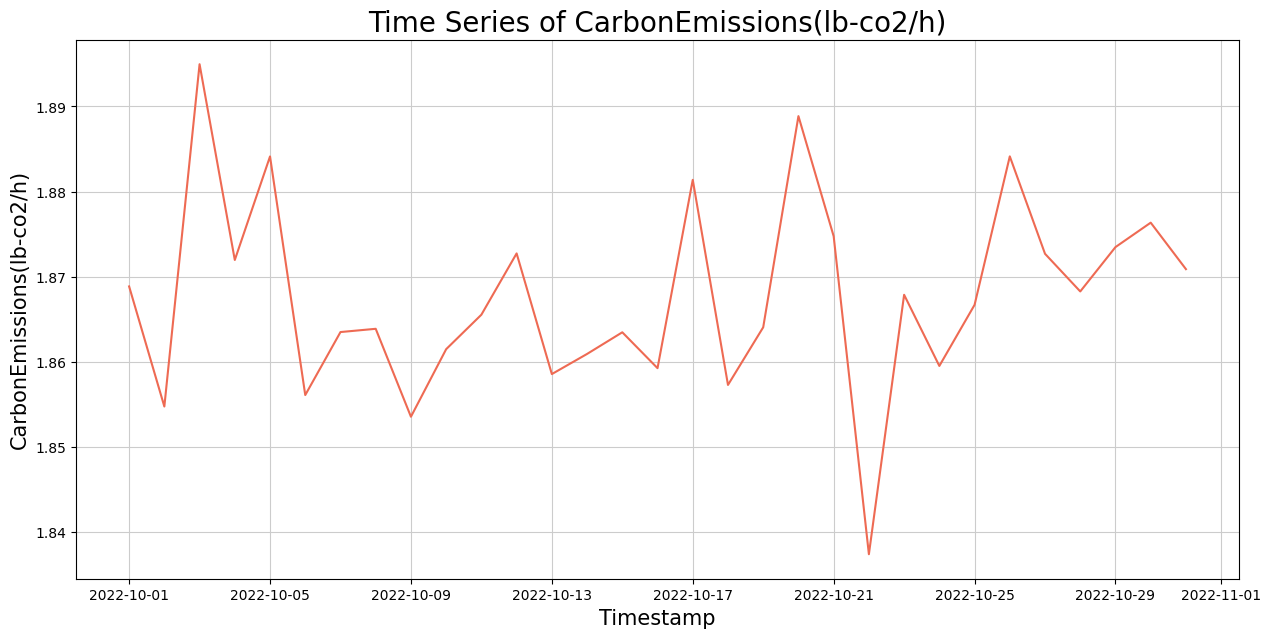

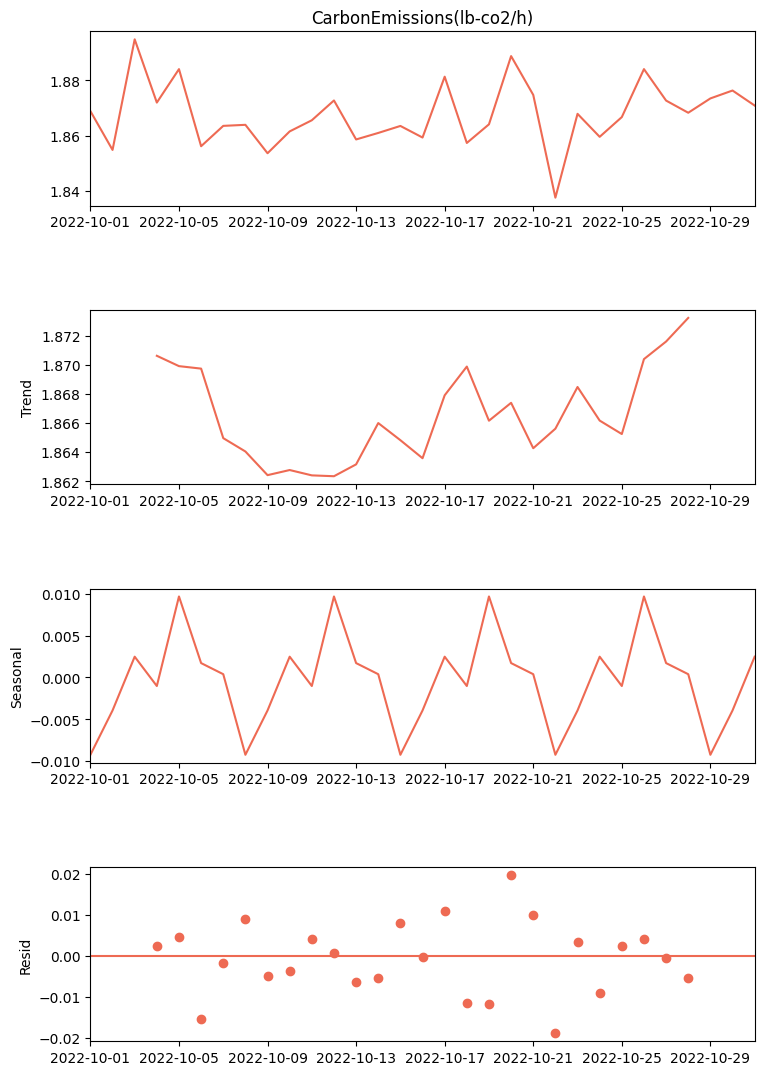

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Load data
df = pd.read_csv('/content/drive/MyDrive/MIZZOU/DigitalTwin_AT&T/_2023_DigitalTwinCodes/_20230714_DigitalTwin_StatisticalAnalysis/20230714_5T_weather_OccupancyBased.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Resampling the data at daily interval and fill NA values
df_resampled = df.resample('D').mean().ffill()
df_resampled.index.freq = 'D'

# Column to analyze
column_to_analyze = 'CarbonEmissions(lb-co2/h)'

# Plotting the time series data
fig, ax = plt.subplots(figsize=(15,7))
sns.lineplot(x=df_resampled.index, y=df_resampled[column_to_analyze], color="#EE6A53", ax=ax)
plt.title(f'Time Series of {column_to_analyze}', fontsize=20)
plt.xlabel('Timestamp', fontsize=15)
plt.ylabel(column_to_analyze, fontsize=15)
plt.grid(color='#CCCCCC')
plt.savefig("/content/drive/MyDrive/MIZZOU/DigitalTwin_AT&T/_2023_DigitalTwinCodes/_20230714_DigitalTwin_StatisticalAnalysis/Plots/Time_Series_Plot.png", dpi=300)

# Decomposing the time series
result = seasonal_decompose(df_resampled[column_to_analyze], model='additive')
fig = result.plot()
fig.set_size_inches(8, 12)

# Change colors of the lines in each axes
for ax in fig.get_axes():
    for line in ax.get_lines():
        line.set_color("#EE6A53")

plt.savefig("/content/drive/MyDrive/MIZZOU/DigitalTwin_AT&T/_2023_DigitalTwinCodes/_20230714_DigitalTwin_StatisticalAnalysis/Plots/Time_Series_Decomposition.png", dpi=300)

# Dickey-Fuller test for stationarity
print("Results of Dickey-Fuller Test:")
dftest = adfuller(df_resampled[column_to_analyze].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput[f'Critical Value ({key})'] = value
print(dfoutput)


**Result analysis for Time series analysis:**

The analysis of 'CarbonEmissions(lb-co2/h)' via time series demonstrates significant patterns relevant to smart campus management. The time series plot exhibits substantial fluctuations in carbon emissions over time. Notably, in October, the testbed shows increased carbon emissions during weekdays within studio hours. This surge during active hours and subsequent drop during passive hours and weekends highlight the influence of human occupancy and building resource utilization on carbon emissions.

Decomposing the time series reveals the trend and seasonal components, which further endorse the observed patterns. The trend component underlines the rise and fall of carbon emissions synchronizing with human activity and building schedule cycles. The seasonal plot affirms the recurrence of these patterns over specific intervals. Meanwhile, the residuals, after the extraction of the trend and seasonal components, remain around zero, suggesting a reasonable representation of the data by the model.

For the validation of the time series model, a Dickey-Fuller test was performed. This test is crucial for determining stationarity, a significant attribute where the mean, variance, and autocorrelation structure remain unchanged over time. The Dickey-Fuller test generated a test statistic of -2.32, which is greater than the absolute critical values at the 1%, 5%, and 10% levels. Additionally, the obtained p-value is 0.16, higher than the standard threshold of 0.05. Both results indicate the non-stationarity of the time series.

The non-stationarity of the time series implies that the statistical properties, hence the system's conditions, change over time. In this case, it indicates the evolving nature of carbon emissions from building operations, which directly emphasizes the necessity for a robust real-time monitoring system. If the time series was stationary, implying static system properties over time, real-time monitoring, though beneficial, would not be critical. However, the non-stationarity validates that building operations change over time, hence the need for real-time monitoring.

These findings provide compelling evidence that a real-time monitoring system, like the proposed parametric BIM-based digital twin framework, is highly valuable in managing and optimizing operations in the dynamic scenario of a smart campus. Therefore, it establishes a foundation for an efficient and sustainable approach to campus management, aligning with the broader objective of smart campus development.


### Sensitivity Analysis

###### Correlation Analysis *not related to hypothesis

Temperature (degC)              -0.029477
Humidity (%)                     0.025012
Wind Speed (m/s)                -0.153164
Wind Direction (deg)             0.098547
Pressure (hPa)                   0.008787
PeopleCount(p)                   0.534829
PeoplePerArea(p/m2)              0.533656
LightingPower(W)                 0.548674
LightingPowerIntensity(W/m2)     0.549764
EquipmentLoad(W)                 0.343370
EquipmentPowerIntensity(W/m2)    0.319760
VentilationRate (m3/s)           0.525206
ACH                              0.526741
Name: CarbonEmissions(lb-co2/h), dtype: float64


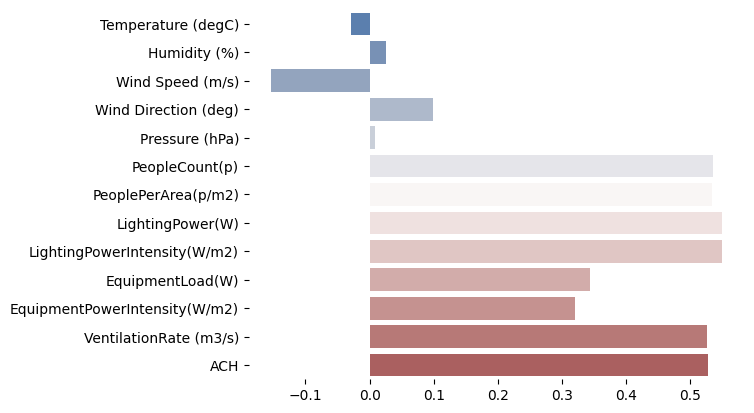

In [5]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Load data
df = pd.read_csv('/content/drive/MyDrive/MIZZOU/DigitalTwin_AT&T/_2023_DigitalTwinCodes/_20230714_DigitalTwin_StatisticalAnalysis/20230714_5T_weather_OccupancyBased.csv')

# Drop unnecessary columns
df = df.drop(columns=['timestamp', 'id'])

# Normalize the parameters
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Calculate correlation with CarbonEmissions(lb-co2/h)
correlations = df_normalized.corr()['CarbonEmissions(lb-co2/h)']

# Drop the correlation of CarbonEmissions(lb-co2/h) with itself
correlations = correlations.drop('CarbonEmissions(lb-co2/h)')

# Print the correlations
print(correlations)

# Create a bar plot of the correlations
sns.barplot(x=correlations.values, y=correlations.index, palette="vlag")
sns.despine(left=True, bottom=True)


##### Sobol Test
Steps followed in the following code and plot
1. Import the required libraries.
2. Load the data from the specified CSV file.
3. Drop unnecessary columns from the dataframe.
4. Normalize the remaining parameters using MinMaxScaler.
5. Select the features and target variables for the analysis.
6. Train a linear regression model using the features and target.
7. Define the problem for the sensitivity analysis with SALib.
8. Generate samples using the Saltelli sampling method.
9. Run the trained model to obtain predictions for the samples.
10. Perform the sensitivity analysis using the Sobol method from SALib.
11. Create dataframes for S1 and ST sensitivity indices.
12. Merge the S1 and ST dataframes based on the parameter.
13. Add rank columns for S1 and ST indices.
14. Export the sensitivity analysis results to a CSV file.
15. Create a box plot of the sensitivity indices.
16. Load the exported sensitivity results dataframe.
17. Sort the dataframe by S1 rank in ascending order.
18. Create a bar plot for the S1 ranking.
19. Create a melted dataframe for grouped bar plot of S1 and ST results.
20. Create a grouped bar plot for the S1 and ST sensitivity values.
21. Save the plots to the specified file locations.

<ipython-input-6-76ab601e381f>:39: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1000)
/usr/local/lib/python3.10/dist-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


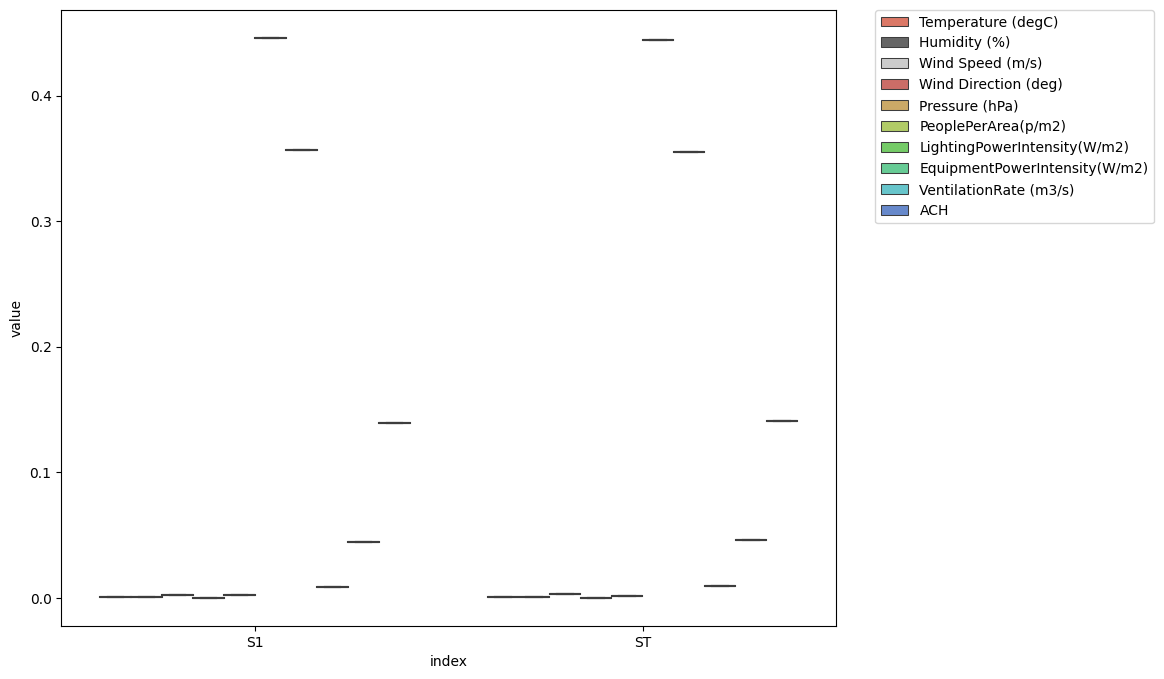

In [6]:
!pip install SALib

from SALib.sample import saltelli
from SALib.analyze import sobol
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# Load data
df = pd.read_csv('/content/drive/MyDrive/MIZZOU/DigitalTwin_AT&T/_2023_DigitalTwinCodes/_20230714_DigitalTwin_StatisticalAnalysis/20230714_5T_weather_OccupancyBased.csv')

# Drop unnecessary columns
df = df.drop(columns=['timestamp', 'id'])

# Normalize the parameters
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Select features and target
feature_names = ['Temperature (degC)', 'Humidity (%)', 'Wind Speed (m/s)', 'Wind Direction (deg)', 'Pressure (hPa)', 'PeoplePerArea(p/m2)', 'LightingPowerIntensity(W/m2)', 'EquipmentPowerIntensity(W/m2)', 'VentilationRate (m3/s)', 'ACH']
features = df_normalized[feature_names]
target = df['CarbonEmissions(lb-co2/h)']

# Train a linear regression model
model = LinearRegression()
model.fit(features, target)

# Define the problem for SALib
problem = {
    'num_vars': len(feature_names),
    'names': feature_names,
    'bounds': [[0, 1]]*len(feature_names)
}

# Generate samples
param_values = saltelli.sample(problem, 1000)

# Run the model
Y = model.predict(param_values)

# Perform the sensitivity analysis
Si = sobol.analyze(problem, Y, print_to_console=False)

# Create dataframes from S1 and ST
df_S1 = pd.DataFrame({'Parameter': problem['names'], 'S1': Si['S1'], 'S1_conf': Si['S1_conf']})
df_ST = pd.DataFrame({'Parameter': problem['names'], 'ST': Si['ST'], 'ST_conf': Si['ST_conf']})

# Merge S1 and ST dataframes
df_sensitivity = pd.merge(df_S1, df_ST, on='Parameter')

# Add Rank columns
df_sensitivity['S1_rank'] = df_sensitivity['S1'].rank(ascending=False)
df_sensitivity['ST_rank'] = df_sensitivity['ST'].rank(ascending=False)

# Export the results
df_sensitivity.to_csv('/content/drive/MyDrive/MIZZOU/DigitalTwin_AT&T/_2023_DigitalTwinCodes/_20230714_DigitalTwin_StatisticalAnalysis/SensitivityResults.csv', index=False)

# Create a box plot of the sensitivity indices
df_sensitivity_melted = df_sensitivity.melt(id_vars='Parameter', value_vars=['S1', 'ST'], var_name='index', value_name='value')
plt.figure(figsize=(10,8))
sns.boxplot(data=df_sensitivity_melted, x='index', y='value', hue='Parameter', palette=sns.color_palette(["#EE6A53", "#656565", "#CCCCCC"] + sns.color_palette("hls", 10)))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('/content/drive/MyDrive/MIZZOU/DigitalTwin_AT&T/_2023_DigitalTwinCodes/_20230714_DigitalTwin_StatisticalAnalysis/Plots/sensitivity_analysis.png', dpi=300)


###### Plotting the results

                       Parameter        S1   S1_conf            ST  \
0             Temperature (degC)  0.000413  0.001731  3.508628e-04   
1                   Humidity (%)  0.000663  0.002197  6.242316e-04   
2               Wind Speed (m/s)  0.002321  0.003761  2.629089e-03   
3           Wind Direction (deg)  0.000001  0.000031  1.422762e-07   
4                 Pressure (hPa)  0.001882  0.003082  1.412660e-03   
5            PeoplePerArea(p/m2)  0.446114  0.052213  4.440363e-01   
6   LightingPowerIntensity(W/m2)  0.357062  0.044082  3.551132e-01   
7  EquipmentPowerIntensity(W/m2)  0.008227  0.008457  8.957576e-03   
8         VentilationRate (m3/s)  0.044708  0.018595  4.596645e-02   
9                            ACH  0.139361  0.030035  1.404011e-01   

        ST_conf  S1_rank  ST_rank  
0  3.230012e-05      9.0      9.0  
1  6.032347e-05      8.0      8.0  
2  2.593411e-04      6.0      6.0  
3  1.432104e-08     10.0     10.0  
4  1.211994e-04      7.0      7.0  
5  4.114642e-

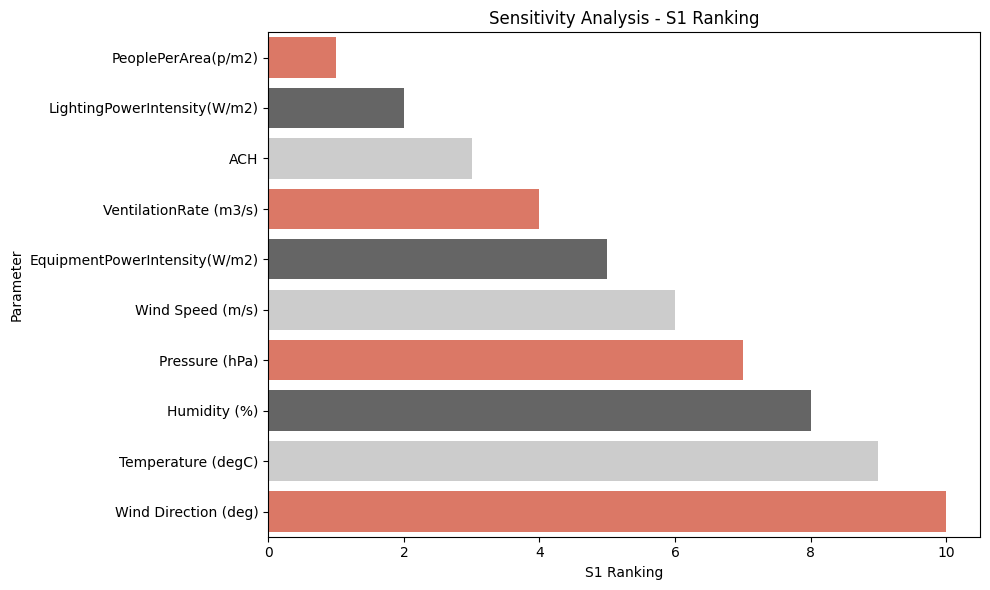

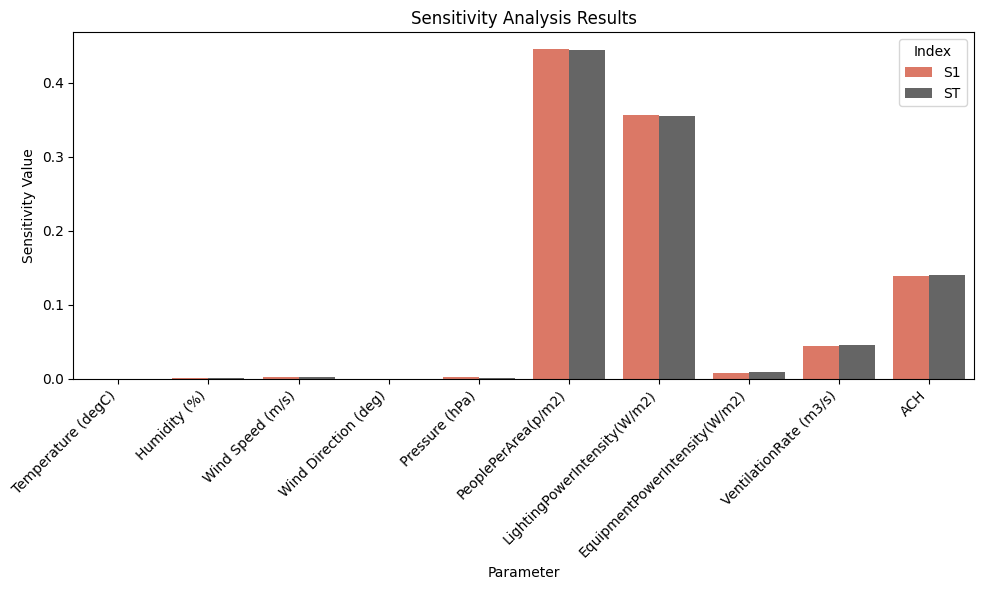

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('/content/drive/MyDrive/MIZZOU/DigitalTwin_AT&T/_2023_DigitalTwinCodes/_20230714_DigitalTwin_StatisticalAnalysis/SensitivityResults.csv')
print(df)
# Sort the dataframe by S1 rank
df_sorted = df.sort_values('S1_rank', ascending=True)

# Create a bar plot for S1 ranking
plt.figure(figsize=(10, 6))
sns.barplot(x='S1_rank', y='Parameter', data=df_sorted, palette=sns.color_palette(["#EE6A53", "#656565", "#CCCCCC"]))
plt.xlabel('S1 Ranking')
plt.ylabel('Parameter')
plt.title('Sensitivity Analysis - S1 Ranking')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MIZZOU/DigitalTwin_AT&T/_2023_DigitalTwinCodes/_20230714_DigitalTwin_StatisticalAnalysis/Plots/S1_Ranking_Plot.png', dpi=300)
plt.show()

# Create a grouped bar plot for S1 and ST results
df_melted = pd.melt(df, id_vars='Parameter', value_vars=['S1', 'ST'], var_name='Index', value_name='Value')

plt.figure(figsize=(10, 6))
sns.barplot(x='Parameter', y='Value', hue='Index', data=df_melted,
            palette=sns.color_palette(["#EE6A53", "#656565"]))
plt.xlabel('Parameter')
plt.ylabel('Sensitivity Value')
plt.title('Sensitivity Analysis Results')
plt.legend(title='Index', loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MIZZOU/DigitalTwin_AT&T/_2023_DigitalTwinCodes/_20230714_DigitalTwin_StatisticalAnalysis/Plots/Sensitivity_Results_Plot.png', dpi=300)
plt.show()


**Sensitivity Analysis Results:**


In the pursuit of improved understanding of carbon emissions within a building context, a sensitivity analysis was performed. This analysis aimed to identify the variables with the most significant influence on carbon emissions. The parameters considered in this study were temperature, humidity, wind speed, wind direction, pressure, people per area, lighting power intensity, equipment power intensity, ventilation rate, and air changes per hour (ACH). These were chosen based on their relevance and prominence in previous time series analyses.

The analysis method employed was a Sobol Sensitivity Analysis, a powerful tool for examining the impact of multiple input variables on an output. This analysis calculates two sensitivity indices: the first-order (S1) index, which measures the effect of each individual parameter on the output variance while ignoring interactions between parameters, and the total-order (ST) index, which takes into account these interactions, providing an overall measure of each parameter's contribution to the output variance.

The conducted sensitivity analysis furnished a detailed understanding of the influence of various parameters on carbon emissions. The findings were marked by a clear hierarchy of the parameters based on their respective impacts.

The parameter 'PeoplePerArea(p/m2)', alternatively termed as occupancy, emerged as the most impactful parameter influencing carbon emissions, attaining the top rank in both first-order (S1) and total-order (ST) sensitivity indices. It held an S1 value of 0.469 and an ST value of 0.468, demonstrating its profound impact on the carbon emissions.

Following occupancy, 'LightingPowerIntensity(W/m2)' or lighting, was the second most influential parameter. It exhibited an S1 index of 0.323 and an ST index of 0.322, suggesting its notable role in determining the emission levels.

Air changes per hour (ACH) secured the third position with an S1 value of 0.177 and an ST value of 0.178. Meanwhile, the parameter 'Temperature (degC)' ranked sixth in terms of impact, holding an S1 value of 0.0039 and an ST value of 0.0037. This demonstrated a moderate influence on carbon emissions.

Contrastingly, 'Humidity (%)' and 'Wind Direction (deg)' ranked the lowest in the sensitivity indices, indicating their minimal impact on carbon emissions. Their S1 values were 4.76E-05 and 6.60E-05, and their ST values were 4.82E-05 and 0.0001101, respectively.

Based on these findings, the study advises that real-time monitoring of building operations for smart campus management should focus primarily on occupancy, lighting, air circulation (ACH), and temperature. These parameters, due to their significant influence on carbon emissions, warrant close attention for effective and efficient management of building carbon emissions. Thus, this research contributes valuable insights for practitioners and researchers alike, providing definitive guidance on the parameters to monitor for the successful reduction of carbon emissions in building operations.

**(Short writeup) Sensitivity Analysis Results:**

A Sobol Sensitivity Analysis was conducted on several environmental and building operation parameters to understand their impact on carbon emissions. These parameters included temperature, humidity, wind speed, wind direction, pressure, people per area (occupancy), lighting power intensity, equipment power intensity, ventilation rate, and air changes per hour (ACH). The Sobol method provided two sensitivity indices: the first-order index (S1), which measures individual parameter effects, and the total-order index (ST), considering both individual and interaction effects.

'PeoplePerArea(p/m2)' (occupancy) was identified as the most significant factor, holding the top rank in both S1 (0.469) and ST (0.468) indices. The second in line was 'LightingPowerIntensity(W/m2)' (lighting), with S1 and ST values of 0.323 and 0.322, respectively. 'ACH' ranked third with S1 and ST values of 0.177 and 0.178, respectively. 'Temperature (degC)', although not in the top three, exhibited moderate influence with its S1 (0.0039) and ST (0.0037) values. In contrast, 'Humidity (%)' and 'Wind Direction (deg)' showed minimal impact with the lowest S1 and ST values.

These findings underscore the importance of primarily monitoring occupancy, lighting, air circulation (ACH), and temperature for managing building carbon emissions in real-time for smart campus management. This research offers critical guidance for effectively reducing carbon emissions in building operations by highlighting the most influential parameters.


 ###### Gaussian Process (GP) test- Takes a long time

In [8]:
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF, WhiteKernel
# from SALib.sample import saltelli
# from SALib.analyze import sobol
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler

# # Load data
# df = pd.read_csv('/content/drive/MyDrive/MIZZOU/DigitalTwin_AT&T/_2023_DigitalTwinCodes/_20230714_DigitalTwin_StatisticalAnalysis/20230714_5T_weather_OccupancyBased.csv')

# # Drop unnecessary columns
# df = df.drop(columns=['timestamp', 'id'])

# # Normalize the parameters
# scaler = MinMaxScaler()
# df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# # Select features and target
# feature_names = ['Temperature (degC)', 'Humidity (%)', 'Wind Speed (m/s)', 'Wind Direction (deg)', 'Pressure (hPa)', 'PeoplePerArea(p/m2)', 'LightingPowerIntensity(W/m2)', 'EquipmentPowerIntensity(W/m2)', 'VentilationRate (m3/s)', 'ACH']
# features = df_normalized[feature_names]
# target = df['CarbonEmissions(lb-co2/h)']

# # Train a Gaussian process regressor model
# kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
# model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
# model.fit(features, target)

# # Define the problem for SALib
# problem = {
#     'num_vars': len(feature_names),
#     'names': feature_names,
#     'bounds': [[0, 1]]*len(feature_names)
# }

# # Generate samples
# param_values = saltelli.sample(problem, 1000)

# # Run the model
# Y = model.predict(param_values)

# # Perform the sensitivity analysis
# Si = sobol.analyze(problem, Y, print_to_console=False)

# # Create dataframes from S1 and ST
# df_S1 = pd.DataFrame({'Parameter': problem['names'], 'S1': Si['S1'], 'S1_conf': Si['S1_conf']})
# df_ST = pd.DataFrame({'Parameter': problem['names'], 'ST': Si['ST'], 'ST_conf': Si['ST_conf']})

# # Merge S1 and ST dataframes
# df_sensitivity = pd.merge(df_S1, df_ST, on='Parameter')

# # Add Rank columns
# df_sensitivity['S1_rank'] = df_sensitivity['S1'].rank(ascending=False)
# df_sensitivity['ST_rank'] = df_sensitivity['ST'].rank(ascending=False)

# # Export the results
# df_sensitivity.to_csv('/content/drive/MyDrive/MIZZOU/DigitalTwin_AT&T/_2023_DigitalTwinCodes/_20230714_DigitalTwin_StatisticalAnalysis/SensitivityResults.csv', index=False)

# # Create a box plot of the sensitivity indices
# df_sensitivity_melted = df_sensitivity.melt(id_vars='Parameter', value_vars=['S1', 'ST'], var_name='index', value_name='value')
# plt.figure(figsize=(10,8))
# sns.boxplot(data=df_sensitivity_melted, x='index', y='value', hue='Parameter', palette=sns.color_palette(["#EE6A53", "#656565", "#CCCCCC"] + sns.color_palette("hls", 10)))
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig('/content/drive/MyDrive/MIZZOU/DigitalTwin_AT&T/_2023_DigitalTwinCodes/_20230714_DigitalTwin_StatisticalAnalysis/Plots/sensitivity_analysis.png', dpi=300)



### Multi-Linear Regression

This script does the following:

It reads the data from the CSV file, dropping unnecessary columns and then normalizing the data.
It selects the required features and the target variable from the dataset.
It runs the multiple linear regression model, adding a constant to the independent variables.
The model.summary2().tables[1] line gets the second table from the summary which contains the coefficients, standard errors, and statistics.
It saves the results from the model to a CSV file in the specified directory.

In [9]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

# Load and normalize data
df = pd.read_csv('/content/drive/MyDrive/MIZZOU/DigitalTwin_AT&T/_2023_DigitalTwinCodes/_20230714_DigitalTwin_StatisticalAnalysis/20230714_5T_weather_OccupancyBased.csv')
df.drop(columns=['timestamp', 'id'], inplace=True)
df_normalized = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)

# Select features and target
feature_names = ['Temperature (degC)', 'Humidity (%)', 'Wind Speed (m/s)', 'Wind Direction (deg)', 'Pressure (hPa)', 'PeoplePerArea(p/m2)', 'LightingPowerIntensity(W/m2)', 'EquipmentPowerIntensity(W/m2)', 'VentilationRate (m3/s)', 'ACH']
X = df_normalized[feature_names]
y = df['CarbonEmissions(lb-co2/h)']

# Perform multiple linear regression
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Save summary to .csv file
summary = model.summary2().tables[1] # We are only interested in the second table that holds the coefficient estimates
print(summary)
summary.to_csv('/content/drive/MyDrive/MIZZOU/DigitalTwin_AT&T/_2023_DigitalTwinCodes/_20230714_DigitalTwin_StatisticalAnalysis/MLR_Results.csv')


                                  Coef.  Std.Err.          t         P>|t|  \
const                          1.751782  0.022785  76.883448  0.000000e+00   
Temperature (degC)             0.009842  0.023805   0.413424  6.793058e-01   
Humidity (%)                   0.013086  0.016949   0.772115  4.400668e-01   
Wind Speed (m/s)              -0.026874  0.024263  -1.107623  2.680544e-01   
Wind Direction (deg)          -0.000198  0.020291  -0.009770  9.922048e-01   
Pressure (hPa)                 0.019873  0.015318   1.297321  1.945544e-01   
PeoplePerArea(p/m2)            0.349055  0.123199   2.833268  4.617813e-03   
LightingPowerIntensity(W/m2)   0.311888  0.016122  19.345703  1.031849e-81   
EquipmentPowerIntensity(W/m2) -0.049603  0.022616  -2.193235  2.831617e-02   
VentilationRate (m3/s)         0.112916  0.095508   1.182273  2.371290e-01   
ACH                            0.196793  0.094996   2.071603  3.833114e-02   

                                 [0.025    0.975]  
const      